In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn import metrics
import cv2
%matplotlib inline

In [2]:
%run ImageDataLoader.ipynb
%run ImageProcessor.ipynb
%run DataExplorer.ipynb
%run DatasetStatistics.ipynb
%run DuplicateDetector.ipynb
%run OversampledDataset.ipynb
%run BatchVisualizer.ipynb
%run VGG16Model.ipynb
%run ResNet34Model.ipynb
%run EfficientNetModel.ipynb
%run Trainer.ipynb

In [3]:
DATA_ROOT = "./data"
TRAIN_DIR = "./data/Training"
TEST_DIR = "./data/Testing"
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
VAL_SPLIT = 0.15

In [4]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(f"Accelerator name: {torch.cuda.get_device_name(device)}")
torch.cuda.empty_cache()

Using cuda device
Accelerator name: NVIDIA GeForce RTX 5070 Ti


In [5]:
loader = ImageDataLoader(TRAIN_DIR, TEST_DIR)
all_files = loader.load_all_images()

print(f"Successfully loaded {len(all_files)} images")

Successfully loaded 3027 images


In [ ]:
duplicate_detector = DuplicateDetector(all_files)
duplicate_detector.detect_duplicates()

if len(duplicate_detector.duplicates) > 0:  # If duplicate files are present
    duplicate_detector.remove_duplicates_from_disk()  # Removing duplicates entirely from disk
    all_files = duplicate_detector.get_unique_files()  # Cleaning list with file paths

In [ ]:
loader.print_dataset_class_count()

Loading 3027 images and converting to grayscale...
  Progress: 1/3027 images
  Progress: 500/3027 images
  Progress: 1000/3027 images
  Progress: 1500/3027 images
  Progress: 2000/3027 images
  Progress: 2500/3027 images
  Progress: 3000/3027 images
Images loaded


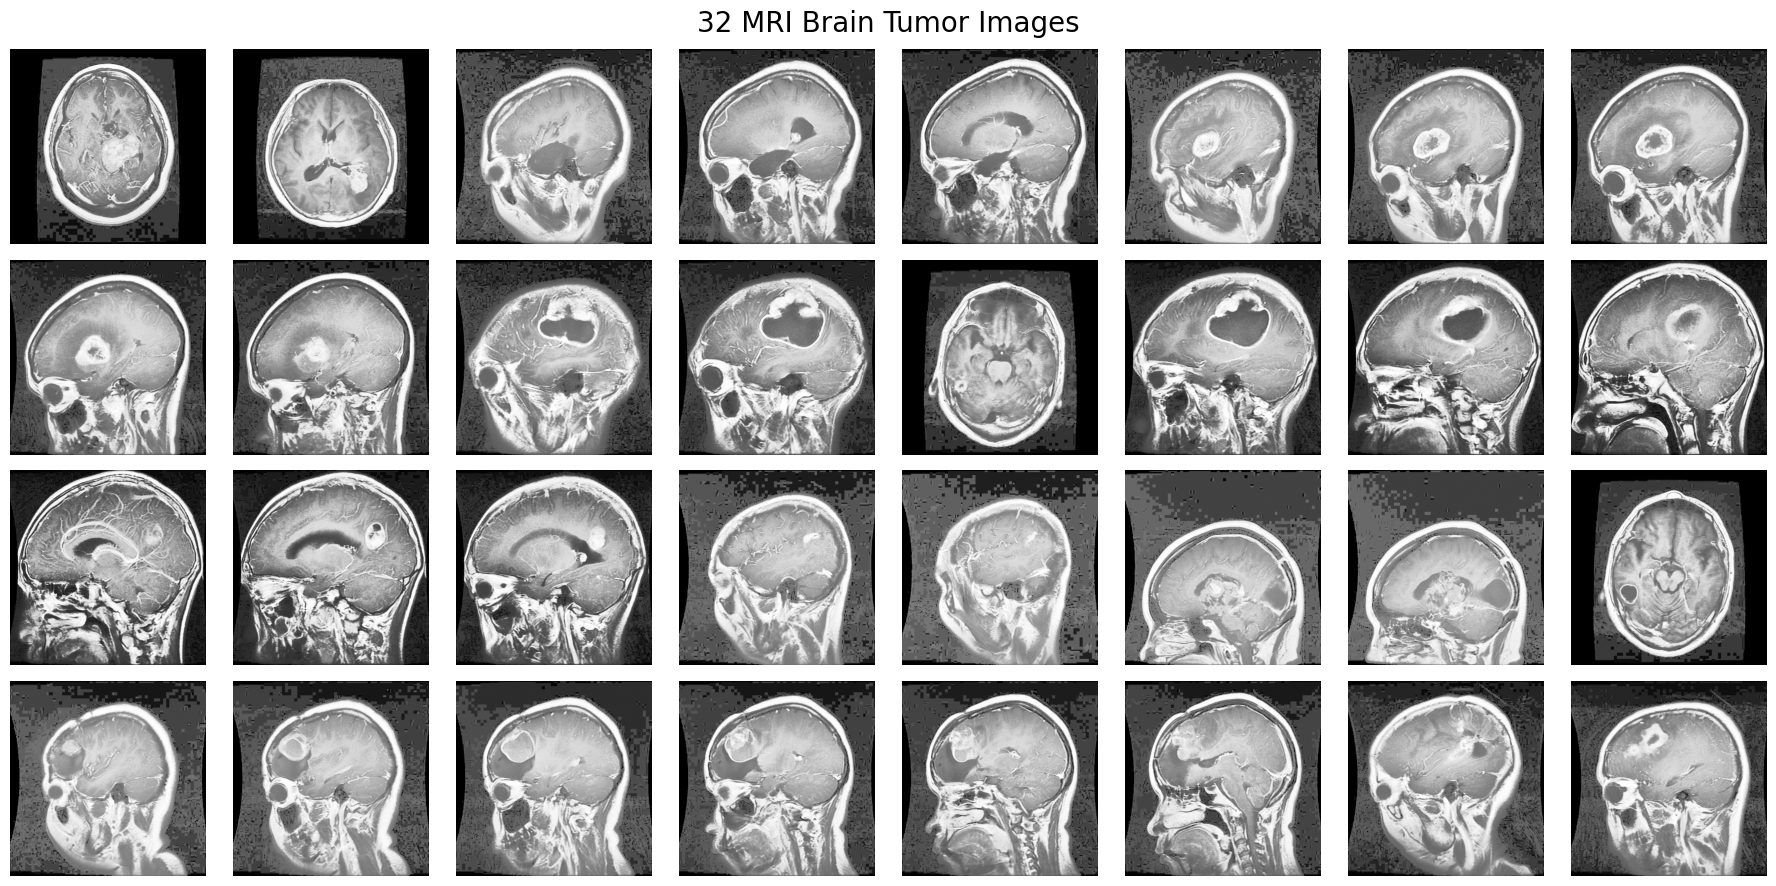

In [ ]:
processor = ImageProcessor(all_files)

processor.load_grayscale_images()
processor.display_image_grid(batch_size=32, figsize=(18, 9), images_per_row=8)

In [ ]:
explorator = DataExplorer(all_files)
explorator.retrieve_sample_of_images(
    [0, len(all_files) // 2, -1],  # equalize=True
)  # First, middle and last image

explorator.plot_histogram()

In [7]:
stats = DatasetStatistics(processor.gray_images)

stats.compute_stats()
stats.print_stats()

MEAN, STD = stats.get_normalized_values()

Dataset Statistics:
	Mean: 114.00
	Standard Deviation: 79.19
	Minimum: 0.00
	Maximum: 255.00
	Median: 111.00


In [ ]:
from PIL import ImageOps


class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        # HistogramEqualization(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(
            brightness=0.15, contrast=0.15
        ),  # consider changing to 0.3 to elevate test acc results
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [ ]:
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        # HistogramEqualization(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3),
    ]
)

In [11]:
base_dataset = datasets.ImageFolder(TRAIN_DIR)

ind = list(range(len(base_dataset)))
targets = [base_dataset.targets[i] for i in ind]

train_idx, val_idx = train_test_split(
    ind, test_size=VAL_SPLIT, random_state=42, stratify=targets
)

In [12]:
val_base = datasets.ImageFolder(TRAIN_DIR, transform=test_transform)
valset = Subset(val_base, val_idx)

In [13]:
trainset = OversampledDataset(TRAIN_DIR, transform=train_transform, indices=train_idx)
testset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

print()
trainset.print_class_distribution()

print()
print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {trainset.classes}")

Before oversampling: 2360
After oversampling: 2645

Class distribution after oversampling:
  glioma_tumor: 695 images
  meningioma_tumor: 692 images
  no_tumor: 570 images
  pituitary_tumor: 688 images

Training samples: 2645
Validation samples: 417
Test samples: 250
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [14]:
g = torch.Generator()
g.manual_seed(42)

In [15]:
train_dl = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(valset, BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
visualizer = BatchVisualizer(trainset.classes, mean=[MEAN] * 3, std=[STD] * 3)

visualizer.visualize_batch(train_dl)
visualizer.visualize_classes(val_dl, 6)

In [ ]:
EPOCHS = 5
LEARNING_RATES = [0.01, 0.001, 0.0001, 0.00001]
NUMBER_OF_CLASSES = 4

In [16]:
models_config = {
    "VGG-16": VGG16Model,
    "ResNet34": ResNet34Model,
    "EfficientNet_B0": EfficientNetModel,
}

In [ ]:
optimizers_config = {
    "sgd": lambda params, lr: optim.SGD(params, lr=lr),
    "sgd_momentum": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    "adam": lambda params, lr: optim.Adam(params, lr=lr),
}

In [17]:
def set_seed(seed=42):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (used)
    torch.cuda.manual_seed_all(seed)  # PyTorch all GPUs
    torch.backends.cudnn.deterministic = True  # CUDA deterministic operations
    torch.backends.cudnn.benchmark = False  # Turn off autotuning for reproducity

In [ ]:
def run_experiment(
    model_class, optimizer_fn, lr, train_dl, val_dl, device, epochs=EPOCHS
):
    set_seed(42)

    model = model_class(NUMBER_OF_CLASSES)
    trainer = Trainer(model, device)
    optimizer = optimizer_fn(model.parameters(), lr)

    history = trainer.fit(train_dl, val_dl, optimizer, epochs)

    return {
        "last_epoch_val_acc": history["val_acc"][-1],
        "best_val_acc": max(history["val_acc"]),
        "last_epoch_val_loss": history["val_loss"][-1],
        "history": history,
    }

In [ ]:
def run_all_experiments(train_dl, val_dl, device):
    res = []

    total = len(models_config) * len(optimizers_config) * len(LEARNING_RATES)
    current = 0

    for model_name, model_class in models_config.items():
        for optim_name, optim_fn in optimizers_config.items():
            for lr in LEARNING_RATES:
                current += 1
                print(f"\n[{current}/{total}] {model_name} + {optim_name} + lr={lr}")

                result = run_experiment(
                    model_class, optim_fn, lr, train_dl, val_dl, device
                )

                res.append(
                    {
                        "model": model_name,
                        "optimizer": optim_name,
                        "learning rate": lr,
                        **result,
                    }
                )
                print(
                    f"Last epoch's validation accuracy: {result['last_epoch_val_acc']:.4f}"
                )

    return res

In [ ]:
results = run_all_experiments(train_dl, val_dl, device)

In [18]:
FINAL_EPOCHS = 50
PATIENCE = 10

In [19]:
set_seed(42)

vgg16_model = VGG16Model()
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.0001)

trainer_vgg16 = Trainer(vgg16_model, device)
vgg16_history = trainer_vgg16.fit(
    train_dl, val_dl, optimizer_vgg16, FINAL_EPOCHS, PATIENCE
)
vgg16_acc, vgg16_preds, vgg16_labels = trainer_vgg16.test(test_dl)
print(f"Test accuracy: {vgg16_acc}")

Epoch 1 out of 50 epochs.                   	Train loss: 0.6732, train accuracy: 0.7168                   	Validation loss: 0.3862, validation accuracy: 0.8465
Epoch 2 out of 50 epochs.                   	Train loss: 0.2973, train accuracy: 0.8854                   	Validation loss: 0.3552, validation accuracy: 0.8777
Epoch 3 out of 50 epochs.                   	Train loss: 0.1682, train accuracy: 0.9346                   	Validation loss: 0.1852, validation accuracy: 0.9233
Epoch 4 out of 50 epochs.                   	Train loss: 0.1018, train accuracy: 0.9629                   	Validation loss: 0.1782, validation accuracy: 0.9400
Epoch 5 out of 50 epochs.                   	Train loss: 0.0989, train accuracy: 0.9686                   	Validation loss: 0.2586, validation accuracy: 0.9233
Epoch 6 out of 50 epochs.                   	Train loss: 0.0738, train accuracy: 0.9732                   	Validation loss: 0.1972, validation accuracy: 0.9424
Epoch 7 out of 50 epochs.               

In [20]:
set_seed(42)

resnet34_model = ResNet34Model()
optimizer_resnet = optim.SGD(resnet34_model.parameters(), lr=0.001, momentum=0.9)

trainer_resnet34 = Trainer(resnet34_model, device)
resnet34_history = trainer_resnet34.fit(
    train_dl, val_dl, optimizer_resnet, FINAL_EPOCHS, PATIENCE
)
resnet34_acc, resnet34_preds, resnet34_labels = trainer_resnet34.test(test_dl)
print(f"Test accuracy: {resnet34_acc}")

Epoch 1 out of 50 epochs.                   	Train loss: 0.8777, train accuracy: 0.6605                   	Validation loss: 0.5146, validation accuracy: 0.7986
Epoch 2 out of 50 epochs.                   	Train loss: 0.3571, train accuracy: 0.8764                   	Validation loss: 0.3389, validation accuracy: 0.8801
Epoch 3 out of 50 epochs.                   	Train loss: 0.2392, train accuracy: 0.9187                   	Validation loss: 0.2500, validation accuracy: 0.9137
Epoch 4 out of 50 epochs.                   	Train loss: 0.2060, train accuracy: 0.9248                   	Validation loss: 0.2276, validation accuracy: 0.9233
Epoch 5 out of 50 epochs.                   	Train loss: 0.1487, train accuracy: 0.9539                   	Validation loss: 0.1957, validation accuracy: 0.9209
Epoch 6 out of 50 epochs.                   	Train loss: 0.1121, train accuracy: 0.9614                   	Validation loss: 0.1760, validation accuracy: 0.9353
Epoch 7 out of 50 epochs.               

In [21]:
set_seed(42)

efficientnet_model = EfficientNetModel()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)

trainer_efficientnet = Trainer(efficientnet_model, device)
efficientnet_history = trainer_efficientnet.fit(
    train_dl, val_dl, optimizer_efficientnet, FINAL_EPOCHS, PATIENCE
)
efficientnet_acc, efficientnet_preds, efficientnet_labels = trainer_efficientnet.test(
    test_dl
)
print(f"Test accuracy: {efficientnet_acc}")

Epoch 1 out of 50 epochs.                   	Train loss: 0.4773, train accuracy: 0.8246                   	Validation loss: 0.4839, validation accuracy: 0.8010
Epoch 2 out of 50 epochs.                   	Train loss: 0.2054, train accuracy: 0.9198                   	Validation loss: 0.2122, validation accuracy: 0.9376
Epoch 3 out of 50 epochs.                   	Train loss: 0.1340, train accuracy: 0.9527                   	Validation loss: 0.1160, validation accuracy: 0.9520
Epoch 4 out of 50 epochs.                   	Train loss: 0.1085, train accuracy: 0.9592                   	Validation loss: 0.1351, validation accuracy: 0.9544
Epoch 5 out of 50 epochs.                   	Train loss: 0.0787, train accuracy: 0.9739                   	Validation loss: 0.1556, validation accuracy: 0.9448
Epoch 6 out of 50 epochs.                   	Train loss: 0.0609, train accuracy: 0.9815                   	Validation loss: 0.1118, validation accuracy: 0.9568
Epoch 7 out of 50 epochs.               

In [22]:
def plot_train_val_accuracy(train_acc, val_acc, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_acc, "r--", label="Training accuracy")
    ax.plot(val_acc, "b-", label="Validation accuracy")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    if title is not None:
        ax.set_title(title, fontsize=10)

    ax.grid()
    ax.legend()

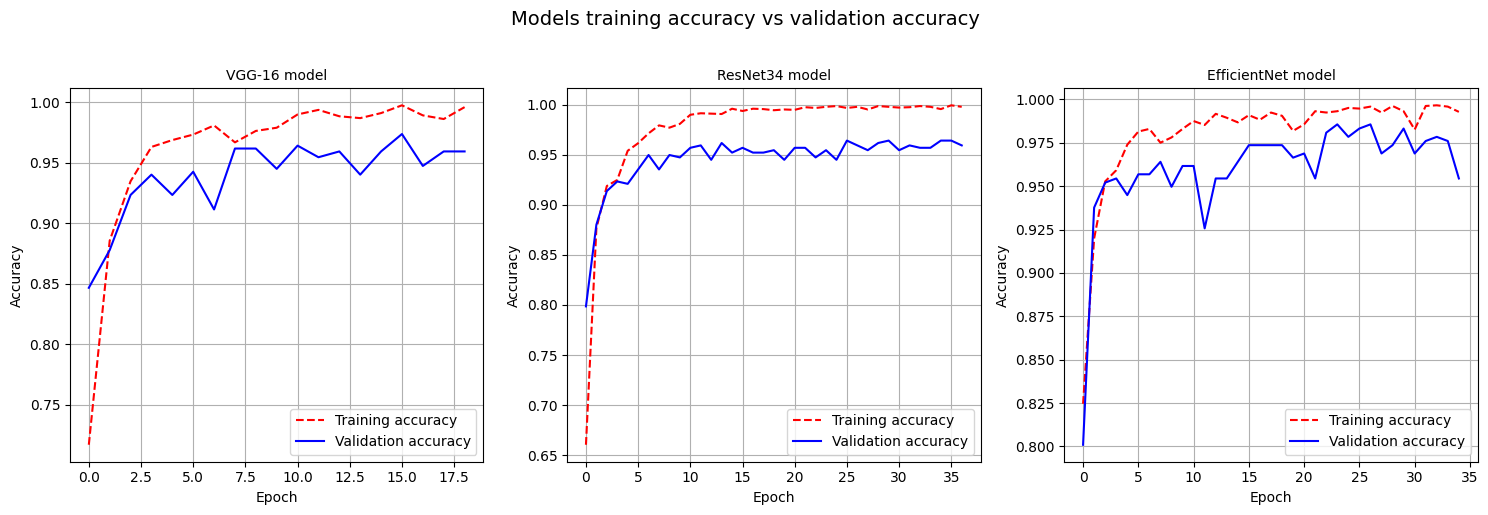

In [23]:
_, axs = plt.subplots(ncols=3, figsize=(15, 5))
plot_train_val_accuracy(
    vgg16_history["train_acc"], vgg16_history["val_acc"], "VGG-16 model", axs[0]
)

plot_train_val_accuracy(
    resnet34_history["train_acc"], resnet34_history["val_acc"], "ResNet34 model", axs[1]
)

plot_train_val_accuracy(
    efficientnet_history["train_acc"],
    efficientnet_history["val_acc"],
    "EfficientNet model",
    axs[2],
)

plt.suptitle("Models training accuracy vs validation accuracy", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

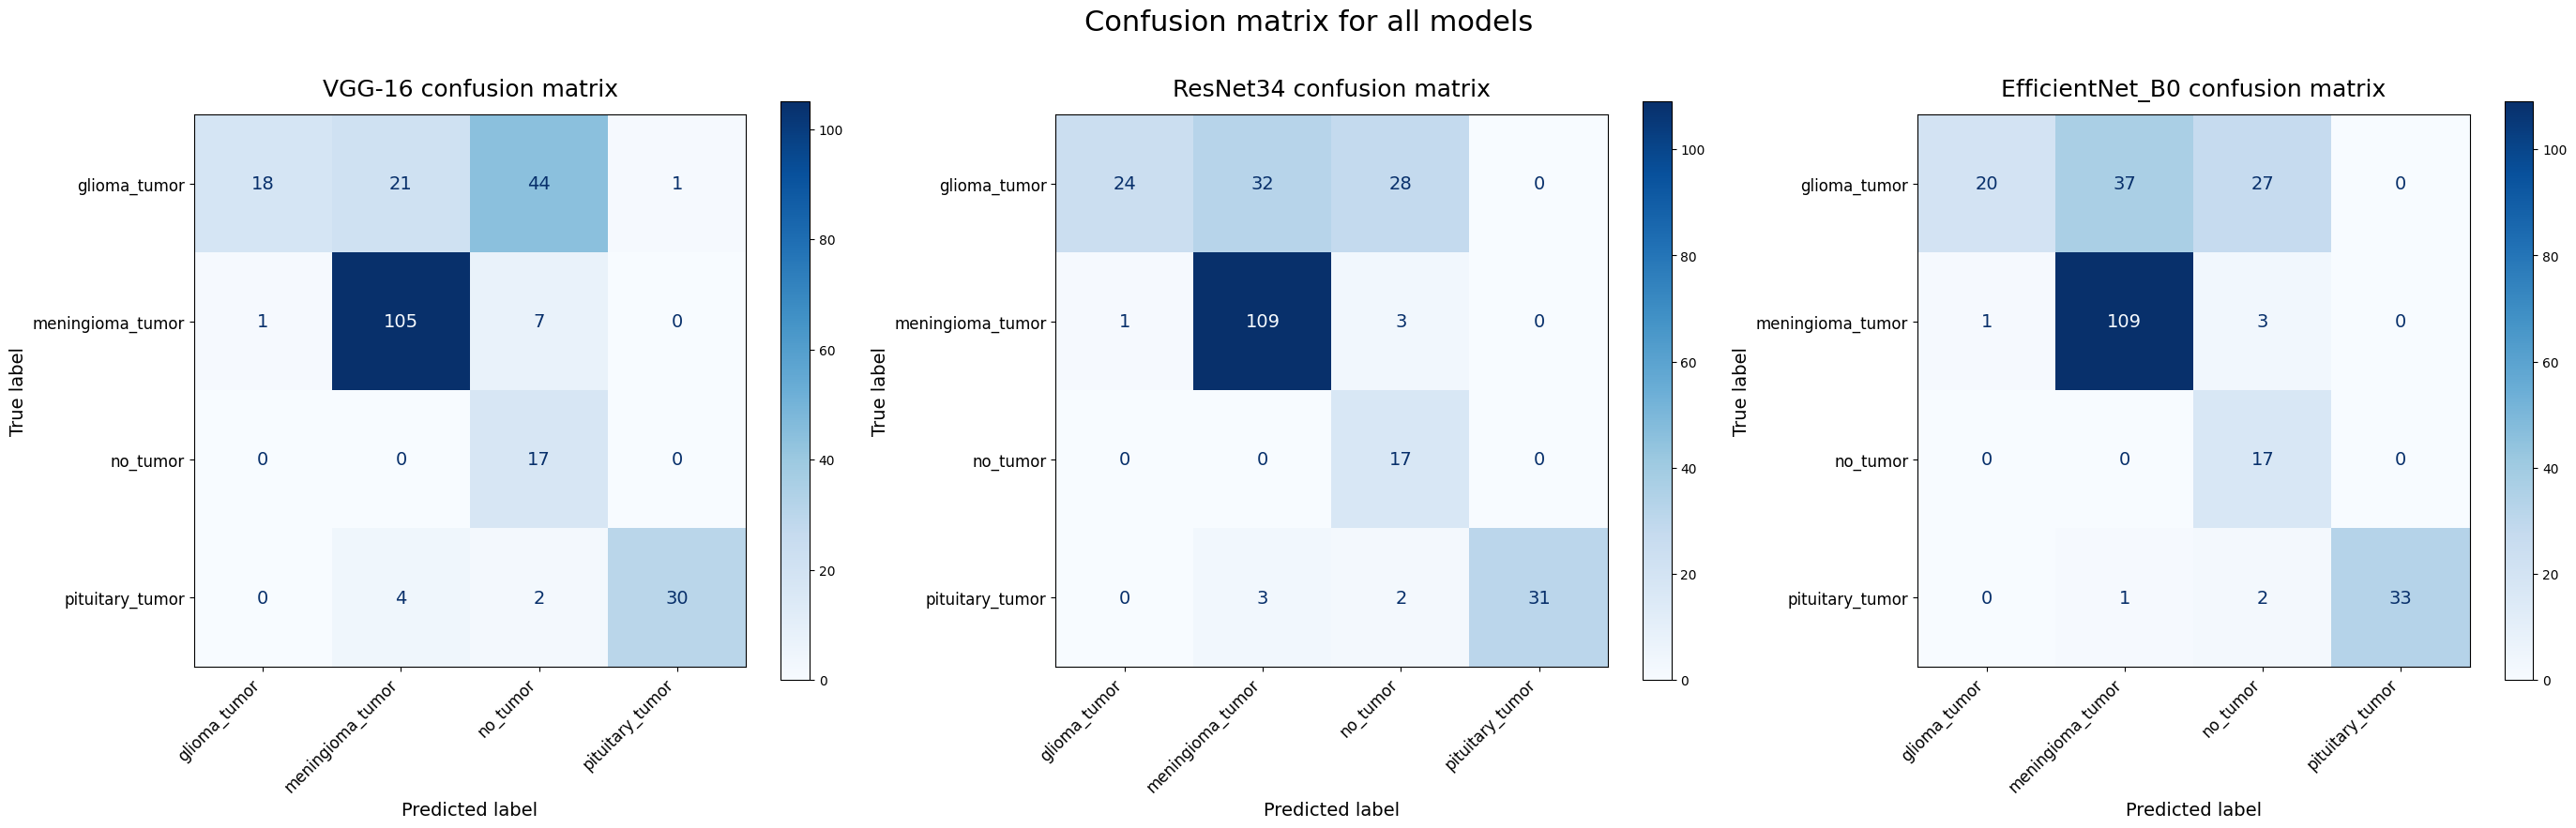

In [24]:
results = [
    [vgg16_labels, vgg16_preds],
    [resnet34_labels, resnet34_preds],
    [efficientnet_labels, efficientnet_preds],
]

_, axs = plt.subplots(ncols=3, figsize=(28, 8))
i = 0

for model in models_config:
    cm = metrics.confusion_matrix(results[i][0], results[i][1])
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=testset.class_to_idx)
    cm_display.plot(cmap="Blues", ax=axs[i], text_kw={"fontsize": 14})

    axs[i].set_title(f"{model} confusion matrix", y=1.02, fontsize=18)

    axs[i].tick_params(axis="x", rotation=45, labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), ha="right")

    axs[i].tick_params(axis="y", labelsize=12)

    axs[i].set_xlabel("Predicted label", fontsize=14)
    axs[i].set_ylabel("True label", fontsize=14)

    i += 1

plt.suptitle("Confusion matrix for all models", fontsize="22", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
glioma_test_paths = []
count = 0
samples = 10

for path, label in testset.samples:
    if label == 0 and count < samples:
        count += 1
        glioma_test_paths.append(path)

glioma_train_paths = []
count = 0

for path, label in trainset.samples:
    if label == 0 and count < samples:
        count += 1
        glioma_train_paths.append(path)

meningioma_test_paths = []
count = 0

for path, label in testset.samples:
    if label == 1 and count < samples:
        count += 1
        meningioma_test_paths.append(path)

_, axs = plt.subplots(1, samples, figsize=(samples * 3, 3))

for i, path in enumerate(glioma_train_paths):
    img = plt.imread(path)
    axs[i].imshow(img)
    axs[i].axis("off")

plt.suptitle(f"Glioma train - {samples} samples of images", fontsize=16)
plt.show()

_, axs = plt.subplots(1, samples, figsize=(samples * 3, 3))

for i, path in enumerate(glioma_test_paths):
    img = plt.imread(path)
    axs[i].imshow(img)
    axs[i].axis("off")

plt.suptitle(f"Glioma test - {samples} samples of images", fontsize=16)
plt.show()

_, axs = plt.subplots(1, samples, figsize=(samples * 3, 3))

for i, path in enumerate(meningioma_test_paths):
    img = plt.imread(path)
    axs[i].imshow(img)
    axs[i].axis("off")

plt.suptitle(f"Meningioma test - {samples} samples of images", fontsize=16)
plt.show()